<a href="https://colab.research.google.com/github/PrayashRM/CNN-MNIST-dataset-model/blob/main/MNIST_digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device avaliable: " , device)

Mounted at /content/drive
Device avaliable:  cuda


# **Loading Dataset**

In [ ]:
from torchvision import datasets

train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.0kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


In [ ]:
train_data[3485][0]

In [ ]:
len(train_data)

60000

In [ ]:
#converting the MNIST data from torchvision into a pd dataframe

train_set = pd.DataFrame( [(img , lab) for img, lab in (train_data)] , columns = [ 'images' , 'labels'])

test_set = pd.DataFrame(  [(img , lab) for img, lab in (test_data)] , columns = [ 'images' , 'labels'])

In [ ]:
print(train_set.shape)
print(test_set.shape)

print(train_set.isnull().sum())
print(test_set.isnull().sum())

print(train_set.columns)
print(test_set.columns)

print(train_set.images.dtype)
print(train_set.labels.dtype)

(60000, 2)
(10000, 2)
images    0
labels    0
dtype: int64
images    0
labels    0
dtype: int64
Index(['images', 'labels'], dtype='object')
Index(['images', 'labels'], dtype='object')
object
int64


In [ ]:
for i in train_set.images:
  if i.size != (28,28):
    print(i.size)

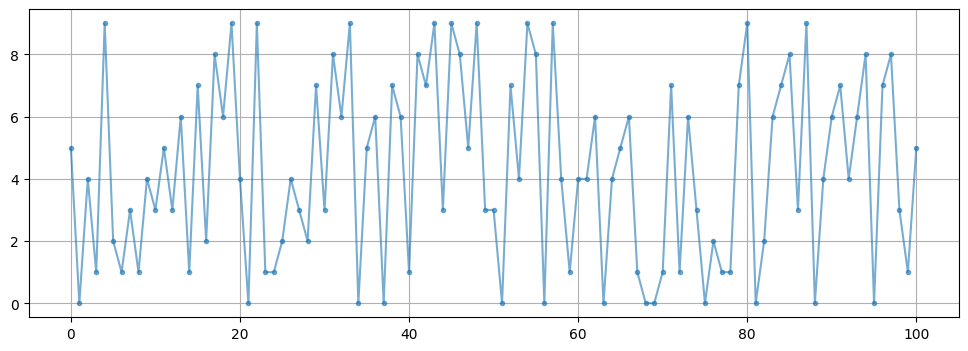

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(train_set['labels'].loc[0 : 100] , marker='.', linestyle='-', alpha=0.6)
plt.grid(True)
plt.show()


In [ ]:
# @title Data Splitting

val_set = train_set.sample( frac = (1/12) , random_state=50 )
train_set = train_set.drop(val_set.index)
#train_set = train_set.drop(val_set)

x_train_set = train_set['images']
y_train_set = train_set['labels']

x_test_set = test_set['images']
y_test_set = test_set['labels']

x_val_set = val_set['images']
y_val_set = val_set['labels']

In [ ]:
# @title **Transformations**

transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),

    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# **Dataset & DataLoader**

In [ ]:
class customdataset(Dataset):

  def __init__( self , X , Y , transform = None ):
    self.X = X
    self.Y = Y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self , index):
    image = self.X.iloc[index]
    label = self.Y.iloc[index]

    if self.transform is not None:
      image = self.transform(image)

    return image , label

In [ ]:
train_loader = DataLoader(customdataset(x_train_set , y_train_set , transform) , shuffle = True , batch_size = 128 , num_workers=2 , pin_memory=True)
val_loader = DataLoader(customdataset(x_val_set , y_val_set , transform) , shuffle = False , batch_size = 128 , num_workers=2 , pin_memory=True)
test_loader = DataLoader(customdataset(x_test_set , y_test_set , transform) , shuffle = False , batch_size = 128 , num_workers=2 , pin_memory=True)


In [ ]:
print(type(y_train_set), y_train_set[:5])

<class 'pandas.core.series.Series'> 0    5
1    0
2    4
3    1
4    9
Name: labels, dtype: int64


# **CNN archtitecture**

In [ ]:
class customMNISTcnn(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d( 1 , 32 , kernel_size=3 , stride = 1)
    self.conv2 = nn.Conv2d( 32 , 64 , kernel_size=3 , stride = 1)

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2 , stride=2)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(1600 , 128)
    self.fc2 = nn.Linear(128 , 10)

    self.dropout = nn.Dropout(0.2)

    self.softmax = nn.Softmax(dim=1)

  def forward(self , x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    return x

# **Training Loop**

In [ ]:
model = customMNISTcnn()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , lr = 0.001)

Epoch:  1  , avg loss:  0.06365764259447365
Epoch:  2  , avg loss:  0.059642413518456526
Epoch:  3  , avg loss:  0.06279124491414878
Epoch:  4  , avg loss:  0.06036463028123212
Epoch:  5  , avg loss:  0.05980134055473257
Epoch:  6  , avg loss:  0.05978172537654119
Epoch:  7  , avg loss:  0.06448788176030787
⛔ Early stopping at epoch 7


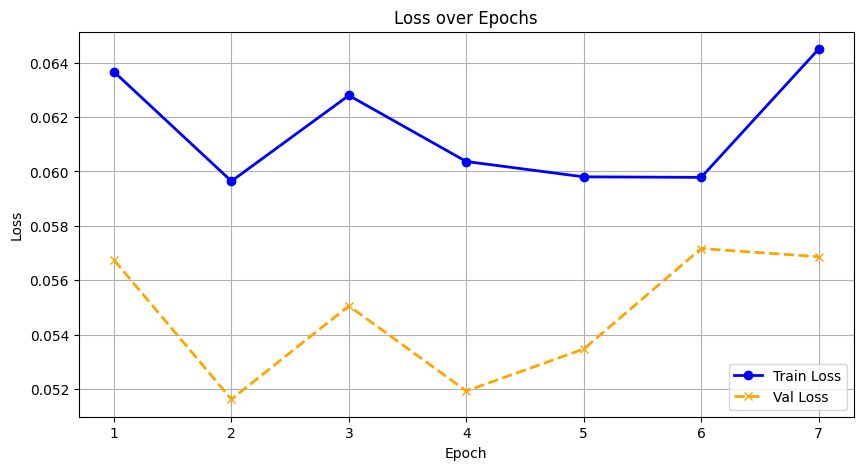

In [ ]:
model.to(device)

losses = []
epoch = []
val = []

epochs = 100

best_val_loss = float('inf')
patience = 5
wait = 0

for i in range(epochs):

    model.train()

    total_epoch_loss = 0

    for x_batch , y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        #forward pass
        prediction = model(x_batch)

        #loss calculation
        loss = criterion(prediction , y_batch)
        total_epoch_loss += loss.item()

        #gradient calculation
        optimizer.zero_grad()
        loss.backward()

        #gradient update
        optimizer.step()

    avg_training_loss = total_epoch_loss/(len(train_loader))
    print('Epoch: ' , i + 1 , ' , avg loss: ' , avg_training_loss)
    losses.append(avg_training_loss)
    epoch.append(i + 1)

    #Validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():

        for x_batch , y_batch in val_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            #forward pass
            prediction = model(x_batch)

            #Loss calculation
            loss = criterion(prediction , y_batch)
            total_loss += loss.item()

        avg_validation_loss = total_loss / (len(val_loader))
        val.append(avg_validation_loss)

    #early stopping
    if avg_validation_loss < best_val_loss:
        best_val_loss = avg_validation_loss
        wait = 0

        current_model_path = "/content/drive/MyDrive/COLAB/Project05/Saved_Models/Project05_MNIST_currentmodel.pth"
        torch.save(model.state_dict(), current_model_path) # Save the best model

    else:
        wait += 1
        if wait >= patience:
            print(f"⛔ Early stopping at epoch {i + 1}")
            break




plt.figure(figsize=(10, 5))
plt.plot(epoch, losses, marker='o', linestyle='-', color='blue', linewidth=2, label='Train Loss')
plt.plot(epoch, val, marker='x', linestyle='--', color='orange', linewidth=2, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title **Evaluation**

model.eval()

correct = 0
total = 0
total_epoch_loss = 0.0

with torch.no_grad():

    for x_batch , y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        #forward pass
        prediction = model(x_batch)

        #loss calculation
        loss = criterion(prediction , y_batch)
        total_epoch_loss += loss.item()

        #accuracy calculation
        predicted_class = torch.argmax(prediction, dim=1)
        correct += (predicted_class == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_epoch_loss / (len(test_loader))
    print(f'Avg Loss is: {avg_loss}')

    accuracy = (correct / total) * 100
    print(f'Accuracy: {accuracy} %')

Avg Loss is: 0.05182461299243843
Accuracy: 98.32 %


In [ ]:
# @title **Model saving and laoding**

best_model_path = "/content/drive/MyDrive/COLAB/Project05/Saved_Models/Project05_MNIST_Bestmodel.pth"

current_model_path = "/content/drive/MyDrive/COLAB/Project05/Saved_Models/Project05_MNIST_currentmodel.pth"

In [ ]:
torch.save(model.state_dict(), best_model_path) #use best_model_path (if want to use the best model saved till now) or current_model_path (if want to use the autosaved best model till now)

In [ ]:
model = customMNISTcnn()
model.load_state_dict(torch.load(current_model_path))  #use best_model_path (if want to use the best model saved till now) or current_model_path (if want to use the autosaved best model till now)
model.to(device)
model.eval()

customMNISTcnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [ ]:
# @title self testing

#First load the required model

#Only apply the necessary required transformations to input the image into the model
transform = transforms.Compose([
    #Always apply
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(( 28 , 28 )),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#Establish the Image path & apply transformations
base_img_path = "/content/drive/MyDrive/COLAB/Project05/test_images"
image_name = "three.jpg"
img_path = os.path.join(base_img_path , image_name)
image = Image.open(img_path)
image = transform(image)

#Bring the image to the same dimension
image = image.unsqueeze(0).to(device) # Have to add one more dimension of batch , as this is a single image in the correct shape , but the expected input is as (batch) 4D , where the batch dimension is the 4th dimension

model.eval()

#Input the image to the loaded model and make prediction
with torch.no_grad():
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()

print(predicted_class)

8
